<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-libraries-to-support-data-and-visualization" data-toc-modified-id="Importing-libraries-to-support-data-and-visualization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing libraries to support data and visualization</a></span></li><li><span><a href="#Define-observations-and-reference-state" data-toc-modified-id="Define-observations-and-reference-state-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define observations and reference state</a></span></li><li><span><a href="#Load-model,-identify-internal-and--external-metabolites-from-model," data-toc-modified-id="Load-model,-identify-internal-and--external-metabolites-from-model,-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load model, identify internal and  external metabolites from model,</a></span></li><li><span><a href="#sort-stoichiometric-matrix,-calculate-unmeasured-fluxes" data-toc-modified-id="sort-stoichiometric-matrix,-calculate-unmeasured-fluxes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>sort stoichiometric matrix, calculate unmeasured fluxes</a></span></li><li><span><a href="#Visualize-the-model-using-d3flux-package-version-0.2.5" data-toc-modified-id="Visualize-the-model-using-d3flux-package-version-0.2.5-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize the model using <a href="https://github.com/pstjohn/d3flux" target="_blank">d3flux package</a> version 0.2.5</a></span><ul class="toc-item"><li><span><a href="#Load-measurement-data" data-toc-modified-id="Load-measurement-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Load measurement data</a></span><ul class="toc-item"><li><span><a href="#Convert-calculated-fluxes-into-relative-output-fluxes" data-toc-modified-id="Convert-calculated-fluxes-into-relative-output-fluxes-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Convert calculated fluxes into relative output fluxes</a></span></li><li><span><a href="#Convert-extracellular-concentrations-into-relative-input-fluxes" data-toc-modified-id="Convert-extracellular-concentrations-into-relative-input-fluxes-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Convert extracellular concentrations into relative input fluxes</a></span></li><li><span><a href="#Convert-intracellular-concentrations-into-relative-metabolite-concentrations" data-toc-modified-id="Convert-intracellular-concentrations-into-relative-metabolite-concentrations-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Convert intracellular concentrations into relative metabolite concentrations</a></span></li><li><span><a href="#Convert-protein-concentrations-into-relative-enzyme-expression" data-toc-modified-id="Convert-protein-concentrations-into-relative-enzyme-expression-5.1.4"><span class="toc-item-num">5.1.4&nbsp;&nbsp;</span>Convert protein concentrations into relative enzyme expression</a></span></li><li><span><a href="#Create-y-matrix" data-toc-modified-id="Create-y-matrix-5.1.5"><span class="toc-item-num">5.1.5&nbsp;&nbsp;</span>Create y matrix</a></span></li></ul></li></ul></li><li><span><a href="#Model-criticism-with-arviz,-ggplot,-seaborn-and-d3flux" data-toc-modified-id="Model-criticism-with-arviz,-ggplot,-seaborn-and-d3flux-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model criticism with arviz, ggplot, seaborn and d3flux</a></span><ul class="toc-item"><li><span><a href="#Plot-95%-highest-posterior-density-(HPD)" data-toc-modified-id="Plot-95%-highest-posterior-density-(HPD)-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Plot 95% highest posterior density (HPD)</a></span></li><li><span><a href="#Plot-prior-and-posterior-Flux-control-coefficients-(FCC)" data-toc-modified-id="Plot-prior-and-posterior-Flux-control-coefficients-(FCC)-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Plot prior and posterior Flux control coefficients (FCC)</a></span><ul class="toc-item"><li><span><a href="#FCCs-with-Seaborn" data-toc-modified-id="FCCs-with-Seaborn-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>FCCs with Seaborn</a></span></li><li><span><a href="#FCC-plot-with-plotnine" data-toc-modified-id="FCC-plot-with-plotnine-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>FCC plot with plotnine</a></span></li><li><span><a href="#plot-itaconate-fccs" data-toc-modified-id="plot-itaconate-fccs-6.2.3"><span class="toc-item-num">6.2.3&nbsp;&nbsp;</span>plot itaconate fccs</a></span></li><li><span><a href="#plot-results-of-overexpressions" data-toc-modified-id="plot-results-of-overexpressions-6.2.4"><span class="toc-item-num">6.2.4&nbsp;&nbsp;</span>plot results of overexpressions</a></span></li></ul></li></ul></li><li><span><a href="#Run-Hamiltonian-Monte-Carlo" data-toc-modified-id="Run-Hamiltonian-Monte-Carlo-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Run Hamiltonian Monte Carlo</a></span></li></ul></div>

# Importing libraries to support data and visualization

In [1]:
import numpy as np
import pandas as pd
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

from tqdm import tqdm_notebook
import d3flux as d3f
from IPython.display import HTML
import json

%matplotlib inline

In [2]:
def make_relative( data, reference_state, data_index, transform = lambda x: x ):
    """Normalizing all our measured data with respect to our reference state."""
    new_data = data.copy()
    data_index = list(data_index)
    return (new_data, 
            new_data.loc[reference_state],  
            new_data.divide(new_data.loc[reference_state]).apply(transform),
            np.array([data_index.index( datum ) 
                   for datum in new_data.columns if datum in data_index]))

def calculate_fluxes_for_each_condition( v, model ):
    """Calculate internal fluxes given external flux measurements"""
    v_calc = v.copy()
    for condition in v_calc.index:
        with model:
            for rxn_id, flux in v_calc.loc[condition].dropna().to_dict().items():
                rxn = model.reactions.get_by_id( rxn_id )
                rxn.lower_bound= flux - 0.01*flux
                rxn.upper_bound = flux + 0.01*flux
                #print(rxn_id)
            model_fluxes = cobra.flux_analysis.pfba(model).to_frame().fluxes
            v_calc.loc[condition] = model_fluxes
    return v_calc

def old_get_internal_and_external_metabolites( model ):
    """An internal metabolite is one that has no sink reaction"""
    ext_mets = []
    int_mets = []
    
    for rxn in model.reactions:
        if 'SK' in rxn.id:
            ext_mets.extend([met.id for met in rxn.metabolites])
    for met in model.metabolites:
        if met.compartment == 'e':
            ext_mets.append( met.id )
    int_mets = set([met.id for met in model.metabolites if met.id not in ext_mets])
    return sorted(int_mets), sorted(set(ext_mets))

def older_get_internal_and_external_metabolites( model ):
    """An external metabolite is one that is extracellular"""
    ext_mets = []
    int_mets = []
    
    for met in model.metabolites:
        if met.compartment == 'c':
            int_mets.append( met.id )
    ext_mets = set([met.id for met in model.metabolites if met.id not in int_mets])
    return sorted(int_mets), sorted(set(ext_mets))

def get_internal_and_external_metabolites( model ):
    """The metabolites of any unbalanced reaction are considered external"""
    ext_mets = set()
    int_mets = set()
    for rxn in model.reactions:
        if len(rxn.metabolites) == 1:
            ext_mets.add([m.id for m in rxn.metabolites][0])
    int_mets = set([met.id for met in model.metabolites if met.id not in ext_mets])
    return sorted(int_mets), sorted(ext_mets)

# Define observations and reference state

In [3]:
strains = ['PC-7', 'PC-ACO',
           'PC-CIT', 'PC-PYC', 'PC-PCK', 'PC-MFS', 'PC-MTT', 'PCM-ACO', 'PCM-PYC',
       'PCM-PCK', 'PCM-MFS', 'PCM-ACO-MFS']

reference_state = 'PCM-ACO-MFS'                                 

                                 

# internal flux


# Load model, identify internal and  external metabolites from model, 

* Add aerobic respiration to the escher map of central metabolism.
* Add lower half of TCA to glycolysis_to_itaconate model 
* Highlight missing reactions of glycolysis_to_itaconate onto Escher map


In [4]:
import cobra
model = cobra.io.load_json_model('glycolysis_to_itaconate.json')
reactions = sorted([rxn.id for rxn in model.reactions])
import warnings

                                 

internal_metabolites, external_metabolites = get_internal_and_external_metabolites( model )
#internal_metabolites #= ['acon_C_c', 'cit_c', 'co2_c', 'h2o_c', 'h_c', 'icit_c']

In [5]:
external_metabolites

['Biomass_e',
 'acon_C_e',
 'acon_T_e',
 'akg_e',
 'cit_e',
 'co2_e',
 'glc_D_e',
 'h2o_e',
 'h_e',
 'itacon_e',
 'o2_e',
 'pyr_e']

# sort stoichiometric matrix, calculate unmeasured fluxes

In [6]:
with model:
    model.remove_reactions(['AKGDam', 'O2tm', 'SUCD3_u6m', 'FUMm', 'PPCK', 'AKGMAL', 'PIt2m',
       'SUCOASm', 'CYOR_u6m', 'SUCD1m', 'AKGDbm', 'ACONTa', 'CYOOm'] )
    N = (cobra.util.create_stoichiometric_matrix(model,
                                                  array_type='DataFrame',
                                                  dtype='int')
          .sort_index(axis=0)
          .sort_index(axis=1))
    reactions, metabolites = list(N.columns), list(N.index)
#display(sol)

v_measured = (pd.read_csv('glycolysis_itaconate_pwy_flux_zhao2019.csv',
                          index_col=0)
              .sort_index(axis=1)
              .astype(float)
              .loc[strains]
              .dropna(axis=1, how = 'all'))
for rxn in reactions:
    if rxn not in v_measured:
        v_measured[rxn] = np.nan
with model:
    v_calc = calculate_fluxes_for_each_condition( v_measured[reactions], model )
v_calc[v_calc == 0].dropna(axis=1).columns

Index([], dtype='object')

# Visualize the model using [d3flux package](https://github.com/pstjohn/d3flux) version 0.2.5

In [7]:
len(reactions)

83

In [8]:
len(metabolites)

103

In [9]:
from IPython.display import HTML
import json
def add_require_js():
    display(HTML('<script src="/static/components/requirejs/require.js"></script>'
               '<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.0/css/bootstrap.min.css">'))

def get_min_max(escher_file):
    if type(escher_file) is str:
        with open(escher_file) as em:
            escher_map = json.load(em)
    else:
        escher_map = escher_file
    min_x,min_y = 1e6,1e6
    max_x,max_y = 0,0
    for node_id, node in escher_map[1]['nodes'].items():
        if node['node_type'] == 'metabolite':
                x,y = float(node['x']),float(node['y'])
                if x < min_x:
                    min_x = x
                elif x > max_x:
                    max_x = x
                if y < min_y:
                    min_y = y
                elif y > max_y:
                    max_y = y
    return min_x,min_y, max_x, max_y

def transfer_coords_to_d3flux(escher_file, model,min_x = 2398, min_y=  2532, max_x = 6404, max_y =9047 ):
    import json
    with open(escher_file) as map_json:
        escher_map = json.load(map_json)
    for node_id, node in escher_map[1]['nodes'].items():
        if node['node_type'] == 'metabolite' and model.metabolites.has_id(node['bigg_id']):
            x,y = float(node['x']),float(node['y'])
            met = model.metabolites.get_by_id(node['bigg_id'])
            met.notes['map_info'] = dict(x=x -min_x, y=y - min_y)
           
    return model

get_ipython().events.register('pre_run_cell', add_require_js)
excluded_metabolites = ['h2o2_m','ppi_m','ppi_c','amp_m','amp_c','q6h2_m','fadh2_m','pi_c','pi_m','ac_m', 'glu_L_c','glu_L_m','gln_L_c','gln_L_m''ac_c','nh4_c','nh4_m','nh3_c','nh3_m','nad_c','nadh_c','nadp_c','nadph_c','nadp_m','nadph_m','nadh_m','nad_m','h2o_m','atp_m','adp_m','h_m','h2o_c','atp_c','adp_c','h_c', 'co2_m','co2_c','coa_c','coa_m']
escher_map = 'iYLI647/iYLI647.central_carbon_and_itaconate.json'
with model:
    min_x,min_y, max_x, max_y = get_min_max( escher_map )
    model = transfer_coords_to_d3flux( 'iYLI647/iYLI647.central_carbon_and_itaconate.json', model)
    sol = model.optimize()
    model.remove_metabolites([met for met in model.metabolites if met.compartment == 'e'])
    svg = d3f.flux_map(model, figsize=(max_x-min_x, max_y-min_y),
                       flux_dict=v_calc.loc['PCM-ACO-MFS'].to_dict(),
                       excluded_metabolites=excluded_metabolites,
                       display_name_format=False)  
svg

In [10]:
import d3flux as d3f
with model:
    sol = model.optimize()
    model.remove_metabolites([met for met in model.metabolites if met.compartment == 'e'])
    svg = d3f.flux_map(model, figsize=(max_x-min_x, max_y-min_y),
                       flux_dict=v_calc.loc['PCM-ACO-MFS'].to_dict(),
                       excluded_metabolites=['h2o2_m','ppi_m','ppi_c','amp_m','amp_c','q6h2_m','fadh2_m','pi_c','pi_m','ac_m', 'glu_L_c','glu_L_m','gln_L_c','gln_L_m''ac_c','nh4_c','nh4_m','nh3_c','nh3_m','nad_c','nadh_c','nadp_c','nadph_c','nadp_m','nadph_m','nadh_m','nad_m','h2o_m','atp_m','adp_m','h_m','h2o_c','atp_c','adp_c','h_c', 'co2_m','co2_c','coa_c','coa_m'],
                       display_name_format=lambda x: x.id)

svg   

## Load measurement data

In [11]:
enzyme_measurements = (pd.read_csv('itaconate_pwy_enzymes_zhao2019.csv', 
                                   index_col=0)
                       .astype(float)
                       .fillna(1)
                       .sort_index(axis=1)
                       .loc[strains])# enzyme data

extracellular_metabolite_measurements = (pd.read_csv('itaconate_pwy_metabolites_zhao2019.csv',
                                                    index_col=0)
                                         #[external_metabolites]
                                         .astype(float)
                                         .fillna(1e-3)
                                         .sort_index(axis=1)
                                         .loc[strains])    # extracellular metabolites
intracellular_metabolite_measurements = (pd.read_csv('itaconate_pwy_metabolites_zhao2019.csv',
                                                    index_col=0)
                                         #[internal_metabolites]
                                         .astype( float )
                                         .sort_index(axis=1)                                         
                                         .loc[strains]
                                         .dropna(axis=1))   # intracellular metabolites
n_exp = len(enzyme_measurements.index)

### Convert calculated fluxes into relative output fluxes

In [12]:
output_flux = 'ITACONtr'
v, v_star, vn, v_inds = make_relative( v_calc, 
                                      reference_state,
                                      reactions
                                 )
v_star[v_star < 1e-15]

Series([], Name: PCM-ACO-MFS, dtype: float64)

In [13]:
from IPython.display import HTML
with model:
    model.remove_reactions(['AKGDam', 'O2tm', 'SUCD3_u6m', 'FUMm', 'PPCK', 'AKGMAL', 'PIt2m',
       'SUCOASm', 'CYOR_u6m', 'SUCD1m', 'AKGDbm', 'ACONTa', 'CYOOm'])
    condition = 'PCM-ACO-MFS'
    for rxn_id, flux in v_measured.loc[condition].dropna().to_dict().items():
                rxn = model.reactions.get_by_id( rxn_id )
                rxn.lower_bound= flux - 0.01*flux
                rxn.upper_bound = flux + 0.01*flux
                #print(rxn_id)
    model_fluxes = cobra.flux_analysis.pfba(model).to_frame().fluxes
    model.metabolites.acon_C_m.summary()
    model_fluxes.to_csv('PCM-ACO-MFS.fluxes.csv',header=False)
    model.metabolites.co2_c.summary()
    model.metabolites.co2_m.summary()
    model.metabolites.co2_e.summary()
    model.metabolites.hco3_c.summary()
    model.metabolites.o2_c.summary()
    model.metabolites.o2_m.summary()
    model.metabolites.dhor_S_c.summary()
    model.metabolites.q6_m.summary()
    model.metabolites.nad_m.summary()
    model.metabolites.Biomass_e.summary()
    model.metabolites.acald_c.summary()
    model.metabolites.pyr_e.summary()
    model.metabolites.pyr_c.summary()
    model.metabolites.pyr_m.summary()

mf = model_fluxes.to_frame().sort_values('fluxes')
HTML(mf.to_html())

In [14]:
v_star.to_csv('v_star.csv',header=False)
v_star

ACONCtr           0.000332
ACONTam           0.120080
ACONTbm           0.109411
ACONisom          0.000065
ACONttr           0.000065
                    ...   
THFtm             0.022430
THRA              0.022430
THRS              0.022430
TPI               0.115399
akg_to_Biomass    0.108143
Name: PCM-ACO-MFS, Length: 83, dtype: float64

### Convert extracellular concentrations into relative input fluxes

In [15]:
y, y_star, yn, y_inds = make_relative( extracellular_metabolite_measurements,
                                       reference_state,
                                       [ex for ex in external_metabolites if ex !='acon_C_e'],
                                       np.log
                                     )
yn.index.name = r'Relative Metabolite $\log\left(mol/L\right)$'
yn

acon_C_e  acon_T_e     akg_e  \
Relative Metabolite $\log\left(mol/L\right)$                                 
PC-7                                         -0.961753  1.352115 -0.471109   
PC-ACO                                       -1.241713  1.352115 -0.100156   
PC-CIT                                       -0.973449  1.352115 -0.233906   
PC-PYC                                       -0.905241  1.352115 -0.121762   
PC-PCK                                       -0.938764  1.352115 -0.106282   
PC-MFS                                       -1.085367  1.352115 -0.378215   
PC-MTT                                       -0.068993 -0.200671 -0.509445   
PCM-ACO                                       0.113329  0.022473 -0.046652   
PCM-PYC                                       0.030637  0.107631 -0.131166   
PCM-PCK                                       0.056170  0.087011 -0.055373   
PCM-MFS                                      -0.040822 -0.120628 -0.315695   
PCM-ACO-MFS                                   0.000000  0.000000  0.000000   

                                                 cit_e  itacon_e     pyr_e  
Relative Metabolite $\log\left(mol/L\right)$                                
PC-7                                         -0.413936 -2.663932  1.123930  
PC-ACO                                       -0.553119 -2.594756  0.186586  
PC-CIT                                       -0.295896 -2.618164  0.743158  
PC-PYC                                       -0.197778 -2.631409 -0.955511  
PC-PCK                                       -0.010794 -2.650252 -0.572519  
PC-MFS                                       -0.283600 -2.589628  0.869038  
PC-MTT                                       -0.293836 -0.302507  0.911149  
PCM-ACO                                      -0.388735 -0.009643 -0.197826  
PCM-PYC                                      -0.220463 -0.029213  0.325422  
PCM-PCK                                      -0.199649 -0.023302  0.050010  
PCM-MFS                                      -0.045498 -0.017425  0.479573  
PCM-ACO-MFS                                   0.000000  0.000000  0.000000

### Convert intracellular concentrations into relative metabolite concentrations

In [16]:
x, x_star, xn, x_inds = make_relative( intracellular_metabolite_measurements,
                                       reference_state,
                                       internal_metabolites,
                                       np.log
                                     )
xn

acon_C_e     akg_e     cit_e  itacon_e     pyr_e
Metabolite $mol/L$                                                  
PC-7               -0.961753 -0.471109 -0.413936 -2.663932  1.123930
PC-ACO             -1.241713 -0.100156 -0.553119 -2.594756  0.186586
PC-CIT             -0.973449 -0.233906 -0.295896 -2.618164  0.743158
PC-PYC             -0.905241 -0.121762 -0.197778 -2.631409 -0.955511
PC-PCK             -0.938764 -0.106282 -0.010794 -2.650252 -0.572519
PC-MFS             -1.085367 -0.378215 -0.283600 -2.589628  0.869038
PC-MTT             -0.068993 -0.509445 -0.293836 -0.302507  0.911149
PCM-ACO             0.113329 -0.046652 -0.388735 -0.009643 -0.197826
PCM-PYC             0.030637 -0.131166 -0.220463 -0.029213  0.325422
PCM-PCK             0.056170 -0.055373 -0.199649 -0.023302  0.050010
PCM-MFS            -0.040822 -0.315695 -0.045498 -0.017425  0.479573
PCM-ACO-MFS         0.000000  0.000000  0.000000  0.000000  0.000000

### Convert protein concentrations into relative enzyme expression

In [17]:
e, e_star, en, e_inds = make_relative( enzyme_measurements,
                                       reference_state,
                                       reactions
                                     )
en

ACONTa  ACONTb  ITACON  ITACONtr  MTT
Enzyme fold change                                       
PC-7                   0.5     0.5     1.0       0.5  0.5
PC-ACO                 1.0     1.0     1.0       0.5  0.5
PC-CIT                 0.5     0.5     1.0       0.5  0.5
PC-PYC                 0.5     0.5     1.0       0.5  0.5
PC-PCK                 0.5     0.5     1.0       0.5  0.5
PC-MFS                 0.5     0.5     1.0       1.0  0.5
PC-MTT                 0.5     0.5     1.0       0.5  1.0
PCM-ACO                1.0     1.0     1.0       0.5  1.0
PCM-PYC                0.5     0.5     1.0       0.5  1.0
PCM-PCK                0.5     0.5     1.0       0.5  1.0
PCM-MFS                0.5     0.5     1.0       1.0  1.0
PCM-ACO-MFS            1.0     1.0     1.0       1.0  1.0

### Create Ey matrix

In [18]:
import pymc3 as pm

import theano
import theano.tensor as T
from theano import sparse
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

import emll
from emll.util import initialize_elasticity

In [19]:
Ey = -N.T[yn.columns]
#Ey.loc['EX_itacon_e', 'itacon_e'] = -1
Ex = -N.T
m_labels = [m for m in metabolites]
r_labels = [r for r in reactions]

ex_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                       for mlabel in m_labels] for rlabel in r_labels]).flatten()

r_compartments = [
    list(r.compartments)[0] if len(r.compartments) == 1 else 't'
    for r in model.reactions
]

m_compartments = [
    m.compartment for m in model.metabolites
]

ll = emll.LinLogLeastNorm(N.values, Ex.values, Ey.values, v_star.values)

n_exp = x.shape[0]
n_exp

12

In [20]:
#import pickle
#with open('inference/glycolysis_itaconate_data.p', 'rb') as f:
#    tiny = pickle.load( f )
#tiny

In [21]:
n_exp = len(xn.index)
n_exp

12

# Define elasticity matrices for internal and external metabolites. 
some enzymes are unmeasured but can vary, others we want to pin at zero

In [ ]:
e_unmeasured_inds = []
e_uncatalyzed_inds = []

for i, rxn_id in enumerate(reactions):
    if rxn_id not in e.columns:
        rxn = model.reactions.get_by_id(rxn_id)
        if ('e' not in rxn.compartments) and (len(rxn.compartments) == 1):
            e_unmeasured_inds += [i]
        else:
            e_uncatalyzed_inds += [i]

e_unmeasured_inds = np.array(e_unmeasured_inds)
e_uncatalyzed_inds = np.array(e_uncatalyzed_inds)
e_indexer = np.hstack([e_inds, e_unmeasured_inds, e_uncatalyzed_inds]).argsort()

with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic(
        'Ex', initialize_elasticity(-Ex.T.values, 'ex', b=0.05, sd=1, alpha=None,
                                    m_compartments=m_compartments,
                                    r_compartments=r_compartments))
                                                        
    Ey_t = pm.Deterministic('Ey', initialize_elasticity(-Ey.T.values, 'ey', b=0.05, sd=1, alpha=None))
    
    e_measured = theano.shared( np.ones( enzyme_measurements.shape ) )
    for i, strain in enumerate(enzyme_measurements.index):
        for j, enzyme in enumerate(enzyme_measurements.columns):
            if enzyme_measurements.loc[reference_state, enzyme] == 1 and enzyme_measurements.loc[strain,enzyme] != 1:
                e_measured = T.set_subtensor( e_measured[i,j], 
                                              pm.Uniform( 'e_{}_{}'.format( strain, enzyme ),
                                                          lower = 0, upper=1) )
            elif enzyme_measurements.loc[reference_state,enzyme] != 1 and enzyme_measurements.loc[strain, enzyme] == 1:
                e_measured = T.set_subtensor( e_measured[i,j], 
                                              pm.Uniform( 'e_{}_{}'.format( strain, enzyme ),
                                                          lower = 1, upper=10) )

                    
    e_unmeasured =  T.ones((n_exp, len(e_unmeasured_inds)))
    e_uncatalyzed = T.ones((n_exp, len(e_uncatalyzed_inds)))
                        
    en_t = T.concatenate(
        [e_measured, e_unmeasured,
         e_uncatalyzed], axis=1)[:, e_indexer]

    en_t = pm.Deterministic('en_t', en_t)
    
    yn_t = T.as_tensor_variable(yn.values)
    
    chi_ss, vn_ss = ll.steady_state_theano(Ex_t, Ey_t, en_t, yn_t)
    pm.Deterministic('chi_ss', chi_ss)
    pm.Deterministic('vn_ss', vn_ss)
    
    vn_subset = T.clip(vn_ss[:, v_inds], 0, 2)
    
    chi_clip = T.clip(chi_ss[:, x_inds], -3, 3)  

    #chi_obs = pm.Normal('chi_obs', mu=chi_clip, sd=0.2,
    #                    observed=xn.values)
    vn_obs = pm.Normal('vn_obs', mu=vn_subset, sd=0.025,
                           observed=vn.values)

In [ ]:
Ex_t

In [23]:
with pymc_model:
    
    trace_prior = pm.sample_prior_predictive()

some enzymes are unmeasured but can vary, others we want to pin at zero

In [34]:
with pymc_model:

    approx = pm.ADVI()
    hist = approx.fit(
        n=40000,
        obj_optimizer=pm.adagrad_window(learning_rate=1E-2),
    )

Average Loss = 2,197.3: 100%|█████████| 40000/40000 [23:24<00:00, 28.91it/s]
Finished [100%]: Average Loss = 2,198.4


In [35]:
import gzip
import pickle
with gzip.open('yarrowia_glycolysis_itaconate_advi.pgz', 'rb') as f:
    advi = pickle.load( f)

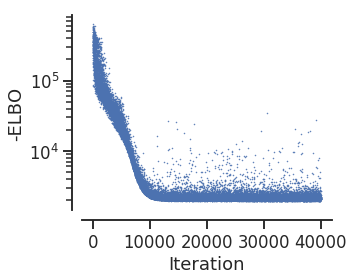

In [36]:
fig = plt.figure(figsize=(5,4))
plt.semilogy(approx.hist, '.', ms=1, rasterized=True)
sns.despine(offset=10)

plt.ylabel('-ELBO')
plt.xlabel('Iteration')
plt.tight_layout()

plt.savefig('fcc_figs/yarrowia_glycolysis_itaconate_elbo.png', dpi=150)

In [37]:
with pymc_model:
    
    trace = hist.sample(500)
    ppc = pm.sample_posterior_predictive( trace )

100%|█████████████████████████████████████| 500/500 [00:12<00:00, 40.27it/s]


In [38]:
import gzip
import pickle
with gzip.open('yarrowia_glycolysis_itaconate_advi.pgz', 'wb') as f:
    pickle.dump({
        'approx': approx,
        'hist': hist,
        'trace': trace,
        'ppc': ppc,
        'trace_prior': trace_prior
    }, f)

# Model criticism with arviz, ggplot, seaborn and d3flux

In [39]:
import arviz as az

inference_data = az.from_pymc3(
            trace=trace,
            prior=trace_prior,
            posterior_predictive=ppc,
            coords={'reactions': reactions,
                    'internal_metabolites': N.index,
                    'external_metabolites': yn.columns},
            dims={'Ex':['reactions', 'internal_metabolites'],
                  'Ey':['reactions', 'external_metabolites']} )
inference_data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

In [75]:
enzyme_vars = ['e_{}_{}'.format(strain, enzyme) 
               for strain  in enzyme_measurements.index
               for enzyme in enzyme_measurements.columns
               if 'PCM' in strain
              ]


nonempty_enzymes = [e for e in enzyme_vars if inference_data.posterior.get(e) is not None]
nonempty_enzymes

['e_PCM-ACO_ITACONtr',
 'e_PCM-PYC_ACONTa',
 'e_PCM-PYC_ACONTb',
 'e_PCM-PYC_ITACONtr',
 'e_PCM-PCK_ACONTa',
 'e_PCM-PCK_ACONTb',
 'e_PCM-PCK_ITACONtr',
 'e_PCM-MFS_ACONTa',
 'e_PCM-MFS_ACONTb']

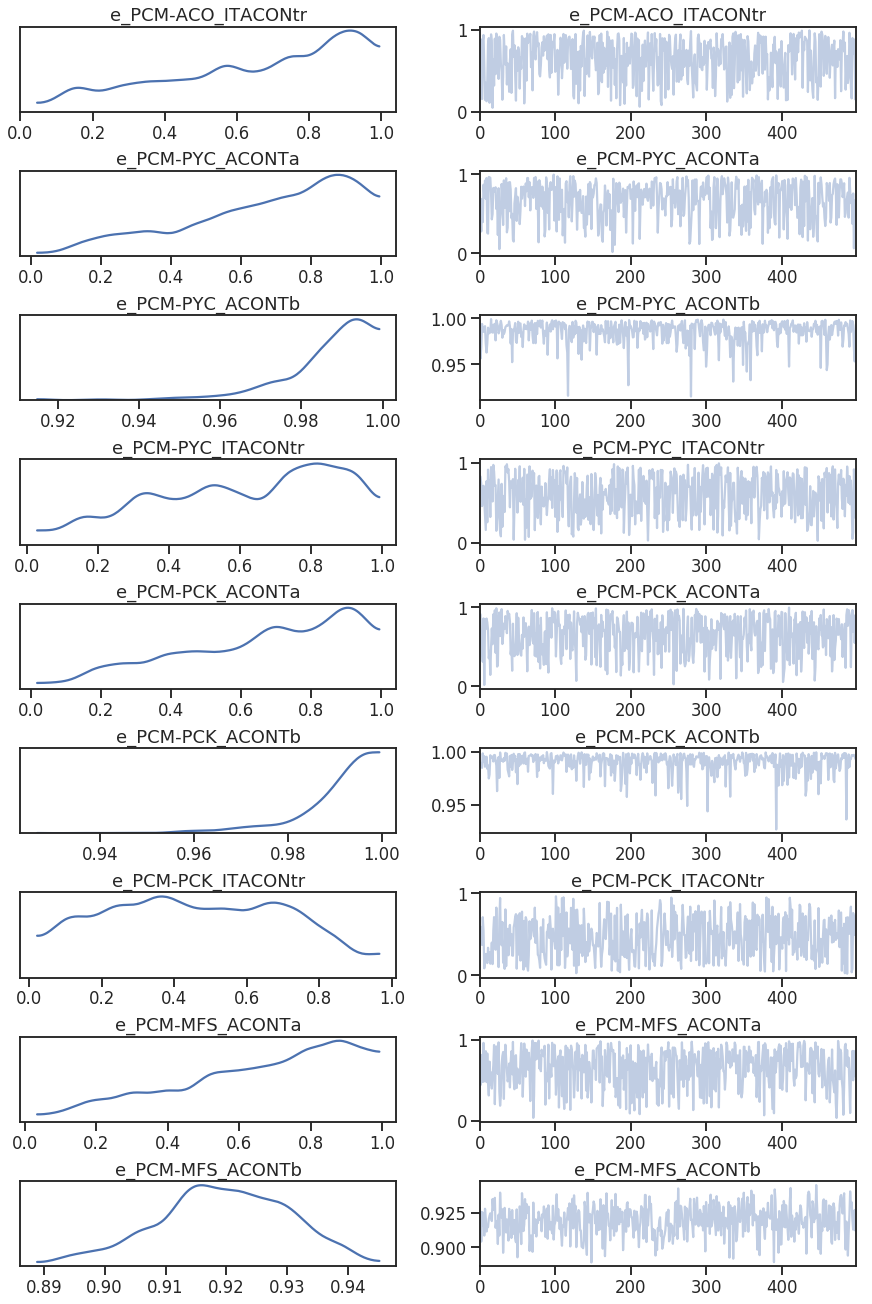

In [76]:
az.plot_trace( inference_data,var_names=nonempty_enzymes  )
plt.savefig('fcc_figs/enzyme_trace.png')

In [40]:
inference_data.posterior

<xarray.Dataset>
Dimensions:                    (chain: 1, chi_ss_dim_0: 12, chi_ss_dim_1: 103, draw: 500, en_t_dim_0: 12, en_t_dim_1: 83, ex_capacity_entries_dim_0: 2106, ex_kinetic_entries_dim_0: 293, external_metabolites: 6, ey_capacity_entries_dim_0: 486, ey_kinetic_entries_dim_0: 12, internal_metabolites: 103, reactions: 83, vn_ss_dim_0: 12, vn_ss_dim_1: 83)
Coordinates:
  * chain                      (chain) int64 0
  * draw                       (draw) int64 0 1 2 3 4 5 ... 495 496 497 498 499
  * ex_capacity_entries_dim_0  (ex_capacity_entries_dim_0) int64 0 1 ... 2105
  * ey_capacity_entries_dim_0  (ey_capacity_entries_dim_0) int64 0 1 ... 484 485
  * ex_kinetic_entries_dim_0   (ex_kinetic_entries_dim_0) int64 0 1 ... 291 292
  * reactions                  (reactions) <U14 'ACONCtr' ... 'akg_to_Biomass'
  * internal_metabolites       (internal_metabolites) object '13dpg_c' ... 'thr_L_c'
  * ey_kinetic_entries_dim_0   (ey_kinetic_entries_dim_0) int64 0 1 2 ... 10 11
  * externa

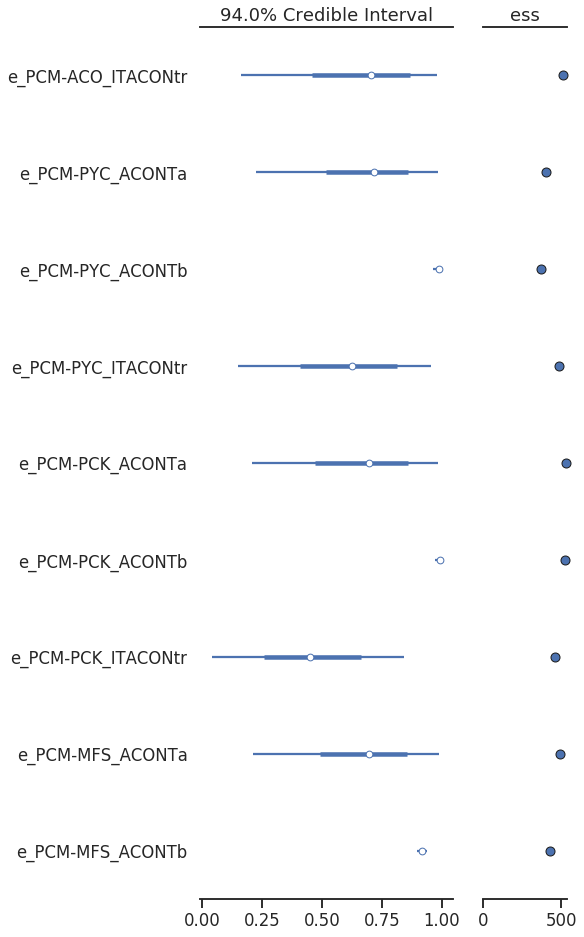

In [77]:
az.plot_forest(inference_data, ess=True, var_names=nonempty_enzymes)
plt.savefig('fcc_figs/enzyme_vars.png')

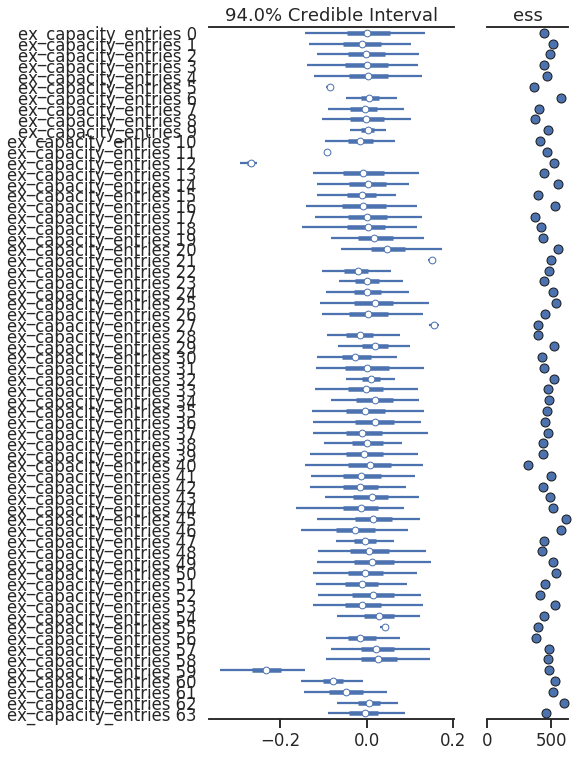

In [29]:
az.plot_forest(inference_data, ess=True, var_names='ex_capacity_entries')
plt.savefig('fcc_figs/ex_capacity_entries.png')

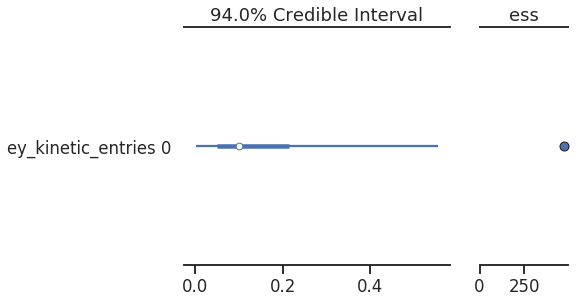

In [219]:
az.plot_forest(inference_data, ess=True, var_names='ey_kinetic_entries')
plt.savefig('fcc_figs/ey_kinetic_entries.png')

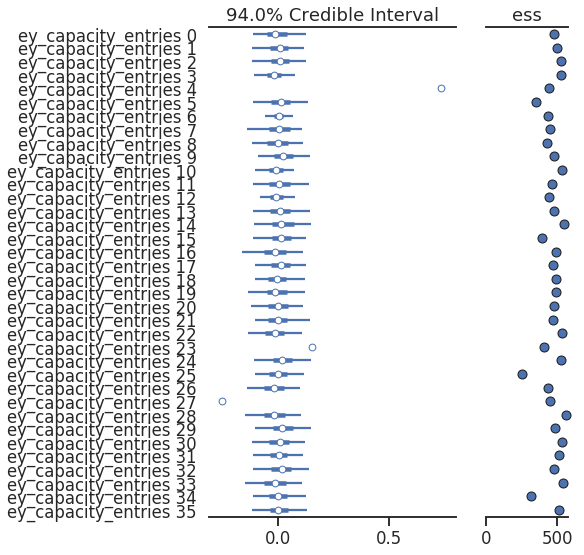

In [31]:
az.plot_forest(inference_data, ess=True, var_names='ey_capacity_entries')
plt.savefig('fcc_figs/ey_capacity_entries.png')

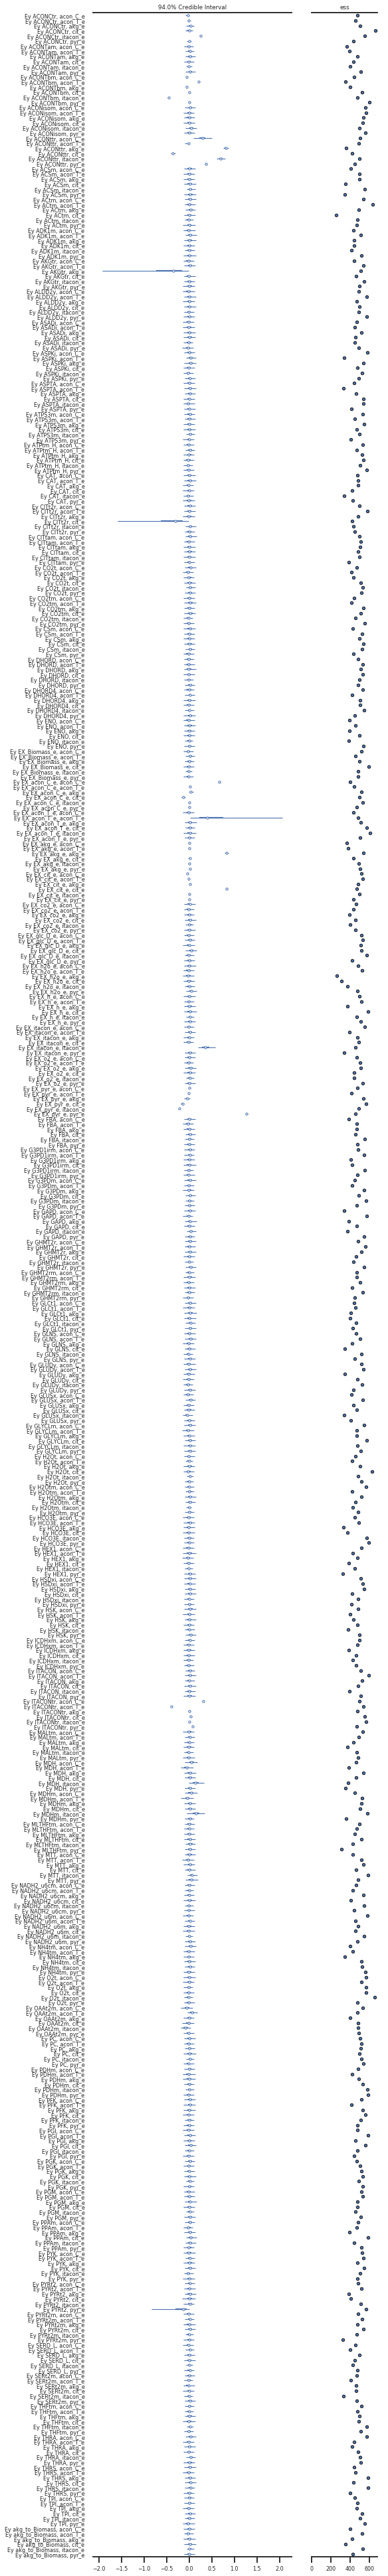

In [30]:
az.plot_forest(inference_data, textsize=8, ess=True, var_names='Ey')
plt.savefig('fcc_figs/Ey_glycolysis_itaconate.png')

ValueError: Image size of 2400x257670 pixels is too large. It must be less than 2^16 in each direction.

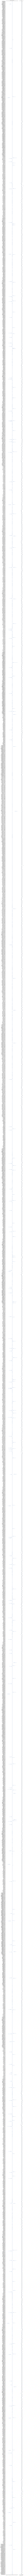

In [31]:
az.plot_forest(inference_data, textsize=8, ess=True, var_names='Ex')
plt.savefig('fcc_figs/Ex_glycolysis_itaconate.png')

## Parity plot

/Users/zuck016/.pyenv/versions/miniconda3-latest/envs/idp_new/lib/python3.6/site-packages/matplotlib/axes/_base.py:380 MatplotlibDeprecationWarning: 
cycling among columns of inputs with non-matching shapes is deprecated.
/Users/zuck016/.pyenv/versions/miniconda3-latest/envs/idp_new/lib/python3.6/site-packages/matplotlib/axes/_base.py:380 MatplotlibDeprecationWarning: 
cycling among columns of inputs with non-matching shapes is deprecated.


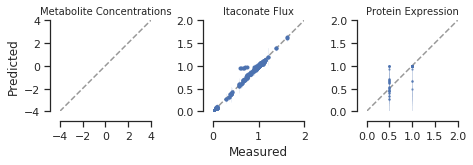

In [32]:
def plot_hpd(ax, real, ppc, error=True, ms=3, alpha=0.5, color='b'):
    
    if error:
        ax.plot(np.vstack([real.values.flatten(), real.values.flatten()]),
                pm.hpd(ppc).reshape(-1, 2).T, color=color, lw=1, alpha=0.05, zorder=0)
        
    ax.plot(real, np.median(ppc, 0), '.', ms=ms, color=color, alpha=alpha, zorder=0)
    
with sns.plotting_context('notebook'):
    fig, ax_matrix = plt.subplots(ncols=3, nrows=1, figsize=(6.5, 3))

    for ax in ax_matrix.flatten():
        ax.set_aspect('equal', adjustable='box')

    ##plot_hpd(ax_matrix[0], ch, ppc['chi_ss'])
    plot_hpd(ax_matrix[1], vn, ppc['vn_obs'], alpha=0.6, ms=6)
    plot_hpd(ax_matrix[2], en,
             trace['en_t'][:, :, e_inds])

    ax_matrix[0].set_xlim([-4, 4])
    ax_matrix[0].set_ylim([-4, 4])

    ax_matrix[1].set_xlim([0, 2])
    ax_matrix[1].set_ylim([0, 2])

    ax_matrix[2].set_xlim([0, 2])
    ax_matrix[2].set_ylim([0, 2])

    ax_matrix[0].set_xticks([-4, -2, 0, 2, 4])
    ax_matrix[0].set_yticks([-4, -2, 0, 2, 4])

    ax_matrix[2].set_xticks([0, 0.5, 1, 1.5, 2])
    ax_matrix[2].set_yticks([0, 0.5, 1, 1.5, 2])

    ax_matrix[0].set_title('Metabolite Concentrations', fontsize='small')
    ax_matrix[1].set_title('Itaconate Flux', fontsize='small')
    ax_matrix[2].set_title('Protein Expression', fontsize='small')
    
    
    ax_matrix[0].plot([-4, 4], [-4, 4], '--', zorder=-1, color='.6')
    ax_matrix[1].plot([0, 2], [0, 2], '--', zorder=-1, color='.6')
    ax_matrix[2].plot([0, 2], [0, 2], '--', zorder=-1, color='.6')
    

    sns.despine(trim=True, offset=10)
    plt.tight_layout()
    
    ax_matrix[1].set_xlabel('Measured')
    ax_matrix[0].set_ylabel('Predicted')
    
    ax_matrix[0].set_rasterization_zorder(1)
    ax_matrix[2].set_rasterization_zorder(1)    
    
    plt.savefig('fcc_figs/parity_glycolysis_itaconate.png', dpi=150)
    

In [68]:
en_hpd = pm.hpd(trace['en_t'][:, :, e_inds]).reshape(-1, 2).T
en_hpd.shape

(2, 36)

In [72]:
real = np.vstack([en.values.flatten(), en.values.flatten()])
real.shape

(2, 60)

In [74]:
e_inds

array([54, 55, 60])

In [33]:
df_elast = pd.DataFrame(
    trace['Ex'].reshape(500, -1), columns=ex_labels
)

df_elast = df_elast.apply(pm.hpd, 0).T.rename(columns={0: 'low', 1: 'high'})
df_elast['type'] = 'kinetic'

e_guess = -N.T.values
e_flat = e_guess.flatten()
df_elast.loc[np.isclose(e_flat, 0), 'type'] = 'capacity'

In [34]:
df_elast['consistent'] = (((df_elast.low < -1E-4) & (df_elast.high < -1E-4)) |
                          ((df_elast.low > 1E-4) & (df_elast.high > 1E-4)))

In [35]:
df_elast.groupby('type').consistent.value_counts()

type      consistent
capacity  False         8255
          True             1
kinetic   True           293
Name: consistent, dtype: int64

In [227]:
e_unmeasured_hpd = pm.hpd(trace['e_unmeasured'])

KeyError: 'Unknown variable e_unmeasured'

In [37]:
output_flux = 'EX_itacon_e'

## Plot prior and posterior Flux control coefficients (FCC)

In [38]:
v_ind = reactions.index(output_flux)
fcc = pd.DataFrame(np.array([ll.flux_control_coefficient(Ex=ex)[v_ind]
                             for ex in trace['Ex']]),
                   columns=N.columns)

fcc_prior = pd.DataFrame(np.array([ll.flux_control_coefficient(Ex=ex)[v_ind]
                                   for ex in trace_prior['Ex']]),
                         columns=N.columns)

# Calculate the fcc values that have 95% Highest Posterior Densities with a consistent direction.
hpd = pm.hpd(fcc.values)
fcc_consistent = np.sign(hpd[:, 0]) == np.sign(hpd[:, 1])

In [39]:
fcc.columns[fcc_consistent]

Index(['EX_itacon_e', 'ITACONtr'], dtype='object')

### FCCs with Seaborn

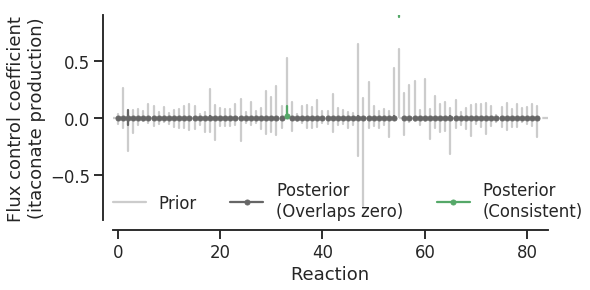

In [76]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

for i, (name, col) in enumerate(fcc.iteritems()):
    
    if name in fcc.columns[fcc_consistent]:
        color='g'
    
        l_g = ax.plot([i, i], pm.hpd(col), color=color)
        dot_g = ax.plot(i, col.median(), '.', color=color, ms=10)

    else:
        color='.4'
    
        l_4 = ax.plot([i, i], pm.hpd(col), color=color)
        dot_4 = ax.plot(i, col.median(), '.', color=color, ms=10)
    
    l_p = ax.plot([i, i], pm.hpd(fcc_prior[name]), color='.8', zorder=0)
    


ax.axhline(0, ls='--', color='.8', zorder=0)

#ax.set_ylim([-5E-5, 1E-4])
# ax.set_xlim([-1, 16])

plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax.set_ylabel('Flux control coefficient\n(itaconate production)')

ax.set_xlabel('Reaction')

plt.legend((l_p[0], (l_4[0], dot_4[0]), (l_g[0], dot_g[0]), ),
           ('Prior', 'Posterior\n(Overlaps zero)', 'Posterior\n(Consistent)'),
           borderaxespad=0, borderpad=0, ncol=3)

#ax.set_xticklabels(reactions, rotation=45)
xs = np.where(fcc_consistent)[0]
ys = fcc.loc[:, fcc_consistent].mean(0).values
labels = fcc.columns[fcc_consistent]

plt.ylim([-.9, .9])
plt.xlim([-1, ll.nr+1])
plt.tight_layout()

sns.despine(trim=False, offset=10)
plt.savefig('fcc_figs/yarrowia_tinymodel_fccs_plot.svg', transparent=True)

In [86]:
#fcc_prior

In [40]:
from plotnine import ggplot, geom_point, geom_errorbar, aes, theme


In [41]:
fcc_posterior = pd.DataFrame({'posterior_mean':fcc.mean(axis=0), 
                      'posterior_ymax':fcc.mean(axis=0) + fcc.std(axis=0),
                      'posterior_ymin':fcc.mean(axis=0) - fcc.std(axis=0),
                             'posterior':'posterior'}).reset_index()
fcc_prior_df = pd.DataFrame({'prior_mean': fcc_prior.mean(axis=0),
                      'prior_ymax': fcc_prior.mean(axis=0) + fcc_prior.std(axis=0),
                      'prior_ymin': fcc_prior.mean(axis=0) - fcc_prior.std(axis=0),
                         'prior': ' prior'},
                      ).reset_index()
fcc_df = pd.DataFrame({ 'index': fcc_prior_df['index'].append(fcc_posterior['index'], ignore_index=True),
                     'mean': fcc_prior_df.prior_mean.append( fcc_posterior.posterior_mean, ignore_index=True),
                     'ymax': fcc_prior_df.prior_ymax.append( fcc_posterior.posterior_ymax, ignore_index=True),
                     'ymin': fcc_prior_df.prior_ymin.append( fcc_posterior.posterior_ymin, ignore_index=True),
                     'Legend': fcc_prior_df.prior.append(fcc_posterior.posterior, ignore_index=True)})
fcc_posterior[fcc_posterior['posterior_mean'] > 0.1]

index  posterior_mean  posterior_ymax  posterior_ymin  posterior
55  ITACONtr        0.970242        0.999247        0.941236  posterior

In [66]:
fcc_posterior.set_index('index')['posterior_mean'].to_csv('glycolysis_to_itaconate_fcc_posterior.csv',header=None)

/Users/zuck016/.pyenv/versions/miniconda3-latest/envs/idp_new/lib/python3.6/site-packages/ipykernel/__main__.py:1 FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


### FCC plot with plotnine

/Users/zuck016/.pyenv/versions/miniconda3-latest/envs/idp_new/lib/python3.6/site-packages/plotnine/ggplot.py:706 UserWarning: Saving 6.4 x 4.8 in image.
/Users/zuck016/.pyenv/versions/miniconda3-latest/envs/idp_new/lib/python3.6/site-packages/plotnine/ggplot.py:707 UserWarning: Filename: fcc_figs/FCC_ggplot_glycolysis_itaconate.png
/Users/zuck016/.pyenv/versions/miniconda3-latest/envs/idp_new/lib/python3.6/site-packages/plotnine/layer.py:517 MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
/Users/zuck016/.pyenv/versions/miniconda3-latest/envs/idp_new/lib/python3.6/site-packages/plotnine/layer.py:517 MatplotlibDeprecationWarning: isinstance(..., numbers.Number)


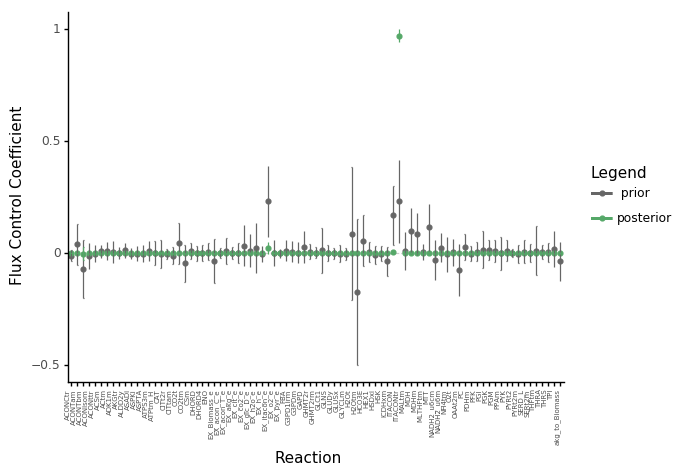

<ggplot: (-9223372036475304395)>

In [42]:
from plotnine import ggplot, aes, geom_point, geom_errorbar, element_text, theme, theme_bw, theme_classic, labs, scale_color_manual, geom_hline, ggsave
g = (ggplot(mapping=aes(x='index', 
                        y='mean', 
                        color='Legend'), 
            data=fcc_df)
    + geom_hline(aes(yintercept=0), 
                 linetype='dashed', 
                 color='0.8')
    + geom_point()
    + geom_errorbar(aes(x='index', 
                        ymin='ymin', 
                        ymax='ymax', 
                        color='Legend'),
                    width=0.1)
    + labs(x='Reaction', 
           y='Flux Control Coefficient')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=90, size=5,
                                     hjust=1))
    + scale_color_manual(values=[".4", "g"]))

ggsave(g,'fcc_figs/FCC_ggplot_glycolysis_itaconate.png')
g

In [43]:
import d3flux as d3f
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=-.05, vmax=.05)
cmap = cm.coolwarm
m = cm.ScalarMappable(norm=norm, cmap=cmap)

def val2hex(flux):
    """ Convert from a [-1, 1] float to the corresponding color,
    with a gray for NaN's """
    if np.isnan(flux):
        return '#808080'
    return mpl.colors.rgb2hex(m.to_rgba(flux))

### plot itaconate fccs

In [44]:
fcc_mean

NameError: name 'fcc_mean' is not defined

In [45]:
fcc_mean = fcc.mean(0)


with model:
    model = transfer_coords_to_d3flux( 'iYLI647/iYLI647.central_carbon_and_itaconate.json', model)
    for rxn in model.reactions:
        if rxn.id in fcc_mean:
            rxn.notes['map_info']['color'] = val2hex(fcc_mean[rxn.id])
    model.remove_metabolites([met for met in model.metabolites if met.compartment == 'e'])
    get_ipython().events.register('pre_run_cell', add_require_js)

    svg = d3f.flux_map(model, figsize=(max_x-min_x, max_y-min_y), flux_dict=fcc.mean(0).abs(), excluded_metabolites=excluded_metabolites, metabolite_dict={met.id: 1 for met in model.metabolites})
svg

In [46]:
fcc_mean.to_csv('EX_')

ACONCtr          -0.000041
ACONTam           0.000055
ACONTbm          -0.002731
ACONisom          0.000079
ACONttr          -0.000228
ACSm              0.000434
ACtm              0.000411
ADK1m            -0.000164
AKGtr             0.000203
ALDD2y            0.000436
ASADi            -0.000119
ASPKi            -0.000355
ASPTA            -0.000118
ATPS3m           -0.000157
ATPtm_H          -0.000137
CAT               0.000223
CITt2r           -0.000163
CITtam            0.000026
CO2t              0.002003
CO2tm            -0.000414
CSm               0.000107
DHORD             0.000333
DHORD4           -0.000067
ENO               0.000109
EX_Biomass_e     -0.000497
EX_acon_C_e      -0.000041
EX_acon_T_e       0.000133
EX_akg_e         -0.000217
EX_cit_e          0.000084
EX_co2_e          0.001087
                    ...   
ICDHxm           -0.000255
ITACON            0.003508
ITACONtr          0.970242
MALtm             0.000485
MDH               0.000712
MDHm              0.000264
M

### plot results of overexpressions

In [48]:
ll_link = emll.LinLogLinkMatrix(ll.N, ll.Ex, ll.Ey, ll.v_star)

fccs = np.array([ll_link.flux_control_coefficient(Ex=ex) for ex in trace['Ex']])
mccs = np.array([ll_link.metabolite_control_coefficient(Ex=ex) for ex in trace['Ex']])

In [50]:
mccs_avg = pd.DataFrame(mccs.mean(axis=0), index=metabolites, columns=reactions)
mccs_avg

ACONCtr   ACONTam     ACONTbm  ACONisom   ACONttr      ACSm  \
13dpg_c    0.015964 -0.200321   -7.506626 -0.107477 -0.107802  0.440351   
2pg_c      0.187319 -0.173400   -9.541005  0.049918  0.048280  0.206270   
3pg_c      0.096498 -0.563230  -23.742681 -0.041025 -0.102187  0.285490   
4pasp_c   -0.141319 -0.397553  -11.573336 -0.147245 -0.681911  0.598340   
Biomass_e -0.007718 -0.088823   -2.870120 -0.042712 -0.033247  0.044062   
ac_c      -0.057533  0.307920    9.122255  0.170802  0.059262 -0.282779   
ac_m       0.080831  0.553692   16.205485  0.146264  0.467405 -0.576332   
acald_c   -0.202102  0.231545   13.139415 -0.076877 -0.107468 -0.259301   
accoa_m   -0.071340  0.416116   16.262219  0.122446  0.248542 -0.780531   
acon_C_c   1.745644  5.946517  167.187130  3.033265  4.262346 -6.413459   
acon_C_e   0.674549  0.276426    8.036307  0.128921  0.183479 -0.267904   
acon_C_m  -0.025689  0.301960    1.942330 -0.036038 -0.029946  0.082802   
acon_T_c   0.547617  1.752757   47.994492  1.387716  0.852890 -2.002935   
acon_T_e  -0.006114  0.003401    0.222995  0.007462  0.383818  0.028098   
adp_c      0.023173  0.044149    1.297511  0.040483  0.055934  0.036838   
adp_m      0.117125  0.506366   14.702173  0.311126  0.437196 -1.115893   
akg_c     -0.021959 -0.498282  -17.615999 -0.181088 -0.180617  0.108138   
akg_e     -0.026693 -0.160955   -4.095579 -0.103726 -0.186908  0.375252   
akg_m     -0.049479 -0.147865   -3.607156 -0.102902 -0.116392  0.228730   
amp_m      0.152234  0.223290    4.742046  0.104825  0.062477  0.766611   
asp_L_c   -0.271211  0.136712   12.944319 -0.233365 -0.882950  2.436299   
aspsa_c   -0.353890 -0.766671  -16.847482 -0.703728 -0.585580 -0.291292   
atp_c     -0.023173 -0.044149   -1.297511 -0.040483 -0.055934 -0.036838   
atp_m     -0.269359 -0.729656  -19.444219 -0.415951 -0.499673  0.349282   
cit_c      0.316800  2.195768   70.566017  0.742447  0.817428 -1.030329   
cit_e     -0.015689  0.950395   34.978658  0.124045 -0.010369  0.009761   
cit_m     -0.403344 -1.071700  -25.110130 -0.868603 -1.092684  2.403254   
co2_c     -0.000236 -0.204748   -8.482689  0.071813 -0.146503 -0.047928   
co2_e      0.031604 -0.071096   -4.098238  0.057230 -0.022266 -0.028553   
co2_m      0.064454  0.056370   -0.426129  0.134786  0.080877 -0.418475   
...             ...       ...         ...       ...       ...       ...   
nadp_c    -0.031051 -0.255075  -11.499252  0.094712 -0.093604 -0.226695   
nadp_m     0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
nadph_c    0.031051  0.255075   11.499252 -0.094712  0.093604  0.226695   
nadph_m    0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
nh4_c     -0.004435  0.187183    6.472568 -0.063313  0.171312  0.369871   
nh4_m      0.073687  0.239461    9.026031 -0.120777  0.274926  0.103104   
o2_c      -0.079881 -0.330968  -10.404680 -0.144610 -0.364226  0.573310   
o2_e       0.076615  0.035290   -0.770875  0.024245  0.134375 -0.375035   
o2_m       0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
oaa_c      0.132967 -0.019260   -4.113665 -0.068411 -0.093034  0.627786   
oaa_m      0.072410 -0.134329   -8.486862 -0.089729 -0.017664  0.552713   
orot_c     0.005488  0.076590    2.210952  0.031711  0.092775 -0.362412   
pep_c      0.242298  0.027639   -3.624504  0.141803  0.058066  0.290862   
phom_c    -0.233148  0.363425   17.645722  0.115590  0.229242 -0.837381   
pi_c       0.150384  0.428447   10.771610  0.261524  0.479125 -0.376710   
pi_m      -0.100385 -0.117791    0.155041 -0.218979 -0.059838  0.462844   
ppi_m      0.013650 -0.072991   -0.773045 -0.037583 -0.001895  0.294915   
pyr_c      0.487638  1.304423   34.196768  0.728451  0.985081 -1.083784   
pyr_e      0.203847  0.402824    9.885959  0.238867  0.390814 -0.533520   
pyr_m      0.463513  1.162259   30.137545  0.673758  0.875315 -1.212903   
q6_m       0.001531 -0.036097   -0.891951 -0.031954 -0.011095 -0.000464   
q6h2_m    -0.001531  0.036097    0.89

In [59]:
HTML(mccs_avg.loc[['itacon_e', 'itacon_c']].T.to_html())

In [61]:
mccs_avg.loc[['itacon_e', 'itacon_c']].T.idxmax(axis=0)

itacon_e    ACONTbm
itacon_c     DHORD4
dtype: object

In [62]:
mccs_avg.loc[['itacon_e', 'itacon_c']].T.min(axis=0)

itacon_e    -0.681784
itacon_c   -35.380548
dtype: float64

In [63]:
mccs_avg.loc[['itacon_e', 'itacon_c']].T.idxmin(axis=0)

itacon_e    THFtm
itacon_c    H2Otm
dtype: object

In [64]:
mccs_avg.to_csv('mcc_glycolysis_to_itaconate.csv')
mccs_avg.loc['itacon_e'].to_csv('itacon_e_mcc.csv')

/Users/zuck016/.pyenv/versions/miniconda3-latest/envs/idp_new/lib/python3.6/site-packages/ipykernel/__main__.py:2 FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [86]:

m_ind = metabolites.index('itacon_e')
mcc = pd.DataFrame(np.array([ll_link.metabolite_control_coefficient(Ex=ex) for ex in trace['Ex']]))
                  
mcc.shape
                   

ValueError: Must pass 2-d input

In [79]:
fcc_eda = pd.Series(fccs[:, :, model.reactions.index('EX_itacon_e')].mean(0), index=r_labels)
mcc_eda = pd.Series(mccs[:, :, model.reactions.index('ITACONtr')].mean(0), index=m_labels)

ValueError: Ex_itacon_e not found

In [52]:
mcc_eda

13dpg_c      0.296478
2pg_c        0.112898
3pg_c        0.112282
4pasp_c     -0.005607
Biomass_e    0.000585
ac_c         0.131574
ac_m         0.083631
acald_c      0.248317
accoa_m      0.052039
acon_C_c     0.348713
acon_C_e     0.173331
acon_C_m     0.056323
acon_T_c     0.097610
acon_T_e     0.007550
adp_c       -0.056435
adp_m       -0.119501
akg_c       -0.115053
akg_e       -0.026101
akg_m       -0.025977
amp_m        0.014829
asp_L_c      0.187475
aspsa_c     -0.239123
atp_c        0.056435
atp_m        0.104672
cit_c        0.231839
cit_e       -0.225976
cit_m        0.469940
co2_c        0.012310
co2_e        0.191041
co2_m        0.046947
               ...   
nadp_c       0.027726
nadp_m       0.000000
nadph_c     -0.027726
nadph_m      0.000000
nh4_c        0.002173
nh4_m       -0.191175
o2_c        -0.072710
o2_e         0.079107
o2_m         0.000000
oaa_c        0.179805
oaa_m        0.282012
orot_c      -0.064680
pep_c       -0.113879
phom_c       0.009415
pi_c      

In [71]:
fcc_eda.abs().to_csv('fcc_eda.csv')
mcc_eda.abs().to_csv('mcc_eda.csv')
with model:
    model = transfer_coords_to_d3flux( 'iYLI647/iYLI647.central_carbon_and_itaconate.json', model)
    for met in model.metabolites:
        #met.notes['map_info'] = {}
        if met.id in mcc_eda:
            met.notes['map_info']['color'] = val2hex(mcc_eda[met.id])

    for rxn in model.reactions:
        #rxn.notes['map_info'] = {}
        if rxn.id in fcc_eda:
            rxn.notes['map_info']['color'] = val2hex(fcc_eda[rxn.id])
    svg = d3f.flux_map(model, figsize=(max_x-min_x, max_y-min_y), excluded_metabolites=excluded_metabolites, flux_dict=fcc_eda.abs(), metabolite_dict=mcc_eda.abs())
svg

/Users/zuck016/.pyenv/versions/miniconda3-latest/envs/idp_new/lib/python3.6/site-packages/ipykernel/__main__.py:1 FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/Users/zuck016/.pyenv/versions/miniconda3-latest/envs/idp_new/lib/python3.6/site-packages/ipykernel/__main__.py:2 FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [56]:
def corrwith(left, right, df=True):
    # demeaned data
    left_tiled = np.repeat(left.values[:, np.newaxis, :], right.shape[0], 1)
    right_tiled = np.repeat(right.values[np.newaxis, :, :], left.shape[0], 0)

    ldem = left_tiled - left_tiled.mean(-1)[:, :, np.newaxis]
    rdem = right_tiled - right_tiled.mean(-1)[:, :, np.newaxis]

    num = (ldem * rdem).sum(-1)

    dom = (left.shape[1] - 1) * left_tiled.std(-1) * right_tiled.std(-1)
    correl = num / dom
    
    if not df:
        return correl
    else: 
        return pd.DataFrame(correl, index=left.index, columns=right.index)

corr_df = corrwith(e, v).T

ValueError: operands could not be broadcast together with shapes (12,12,5) (12,12,19) 

In [57]:
corr_df = corr_df.reindex(columns=r_labels).loc['ccmuac']

NameError: name 'corr_df' is not defined

In [224]:
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cmap = cm.coolwarm
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for met in model.metabolites:
    met.notes['map_info']['color'] = '#d3d3d3'

for rxn in model.reactions:
    rxn.notes['map_info']['color'] = val2hex(corr_df[rxn.id])
    
d3f.flux_map(model, flux_dict=corr_df.fillna(0).abs())

# Run Hamiltonian Monte Carlo

In [62]:
with pymc_model:
    trace_hmc = pm.sample(500, random_seed=123, 
                      cores=4, init='nuts')

Auto-assigning NUTS sampler...
Initializing NUTS using nuts...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_PCM-MFS_ACONTb, e_PCM-MFS_ACONTa, e_PCM-PCK_ITACONtr, e_PCM-PCK_ACONTb, e_PCM-PCK_ACONTa, e_PCM-PYC_ITACONtr, e_PCM-PYC_ACONTb, e_PCM-PYC_ACONTa, e_PCM-ACO_ITACONtr, e_PC-MTT_ITACONtr, e_PC-MTT_ACONTb, e_PC-MTT_ACONTa, e_PC-MFS_MTT, e_PC-MFS_ACONTb, e_PC-MFS_ACONTa, e_PC-PCK_MTT, e_PC-PCK_ITACONtr, e_PC-PCK_ACONTb, e_PC-PCK_ACONTa, e_PC-PYC_MTT, e_PC-PYC_ITACONtr, e_PC-PYC_ACONTb, e_PC-PYC_ACONTa, e_PC-CIT_MTT, e_PC-CIT_ITACONtr, e_PC-CIT_ACONTb, e_PC-CIT_ACONTa, e_PC-ACO_MTT, e_PC-ACO_ITACONtr, e_PC-7_MTT, e_PC-7_ITACONtr, e_PC-7_ACONTb, e_PC-7_ACONTa, ey_capacity_entries, ey_kinetic_entries, ex_capacity_entries, ex_kinetic_entries]
Sampling 4 chains:   0%|                        | 0/1200000 [00:00<?, ?draws/s]


ValueError: Not enough samples to build a trace.